In [2]:
import pandas as pd
import settings

df = pd.read_csv(settings.ASSEMBLED_DIR + "\\Model_data.csv")
df.head(5)

,DAY,DATE_x,MONTH,YEAR,DEMAND,MAX_TEMP,MIN_TEMP,Holiday_Flag,Weekened_Flag,STATE_QLD,STATE_SA,STATE_TAS,STATE_VIC
0,1,2014-01-01,1,2014,0.819194,0.913132,1.257606,0.0,0,0,0,0,0
1,1,2014-01-01,1,2014,0.412829,1.338234,1.361019,0.0,0,1,0,0,0
2,1,2014-01-01,1,2014,-1.059004,0.979379,0.812865,0.0,0,0,1,0,0
3,1,2014-01-01,1,2014,-1.248662,-0.734138,-0.987926,0.0,0,0,0,1,0
4,1,2014-01-01,1,2014,-0.077330,0.700581,0.651904,0.0,0,0,0,0,1


In [3]:
demand = pd.DataFrame({'DEMAND':df.groupby(['DATE_x'])['DEMAND'].sum()}).reset_index()
demand.set_index(demand['DATE_x'], inplace = True)
demand.drop(['DATE_x'], axis = 'columns', inplace = True)
demand.sort_index(inplace=True)
demand

,DEMAND
DATE_x,
2014-01-01,-1.152974
2014-01-02,-0.152163
2014-01-03,-0.001628
2014-01-04,-0.393165
2014-01-05,-0.646320
...,...
2018-12-27,0.396279
2018-12-28,0.641387
2018-12-29,-0.062260


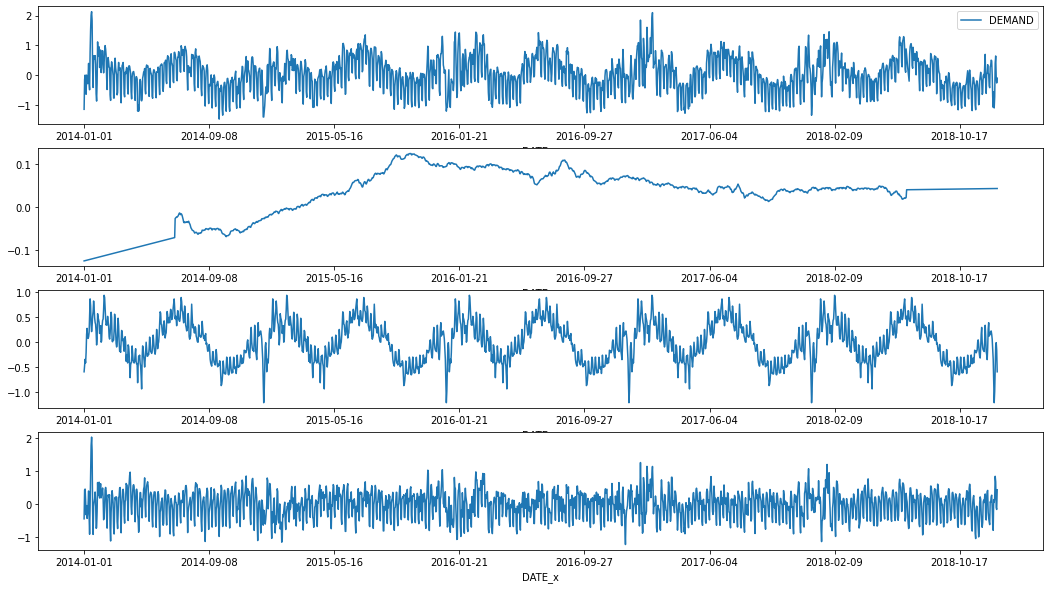

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
decomp = seasonal_decompose( x = demand,  model = 'additive', period= 365, extrapolate_trend = 365)
trends = decomp.trend
seasonals = decomp.seasonal
resids = decomp.resid



fig, axes = plt.subplots(4,1,  figsize= (18,10))
demand.plot(ax=axes[0])
trends.plot(ax=axes[1])
seasonals.plot(ax=axes[2])
resids.plot(ax=axes[3])


In [5]:
#Test to Check stationary
#   Mean should be constant – It conveys that there is no trend in the Time Series.
# Variance should be constant – It conveys that there is no heteroscedasticity
# (difference in the variance of a variable across the different intervals of time in the same data).
# Autocorrelation should be constant – To remove randomness among the data and make a constant pattern relationship.
# No Periodic component – It means that there is no seasonality.
import numpy as np
data_array = np.array(demand['DEMAND'])
partitions = np.split(data_array, indices_or_sections=11)
print("Mean of Partitions")
np.mean(partitions, axis=1)

Mean of Partitions


array([ 0.03217114, -0.03775568, -0.08482391,  0.1808996 ,  0.1266464 ,
        0.16424584,  0.0156798 ,  0.08773462, -0.08759886,  0.14084768,
       -0.17768836])

Variance of Partitions


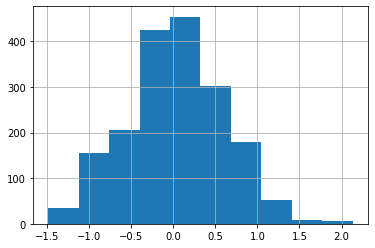

In [6]:
print("Variance of Partitions")
np.var(partitions, axis=1)
pd.Series(data_array).hist()

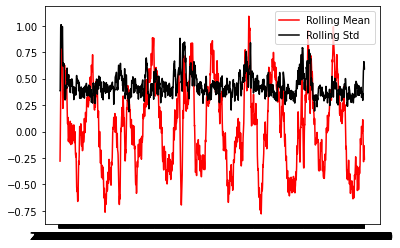

In [7]:
rolmean = demand.rolling(12).mean()
rolstd = demand.rolling(12).std()
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend()

In [8]:
# Augmented Dickey-Fuller(ADF) Test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_array)
adf, pvalue, usedlag, nobs, critical_values, icbest

# ADF < than all the thresholds, means series is stationary,we can safely reject null hypothesis of its being time dependent component

(-4.894293028590845,
 3.5777453344843795e-05,
 24,
 1801,
 {'1%': -3.4339861159726306,
  '5%': -2.863146142843122,
  '10%': -2.5676250581282964},
 239.7711015667419)

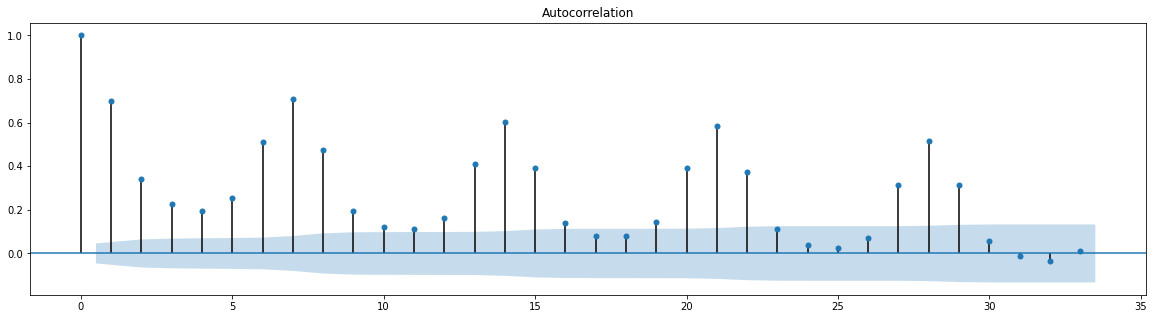

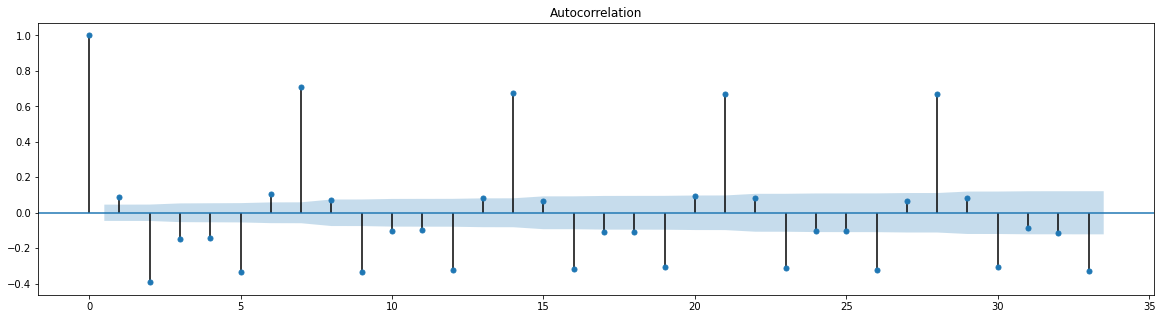

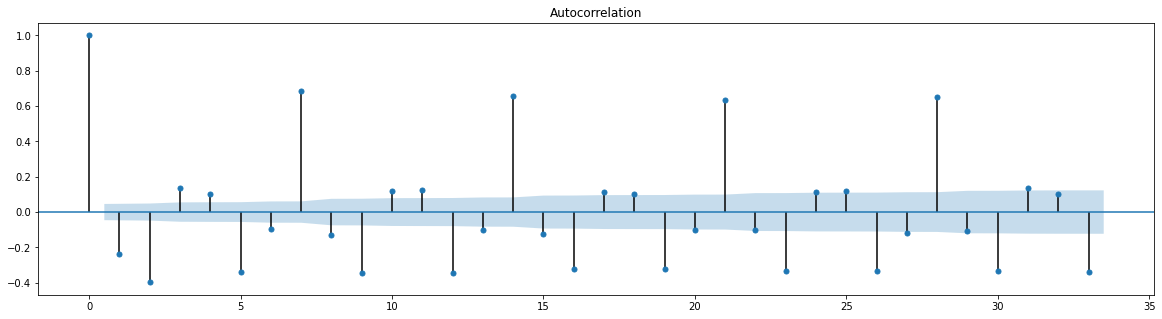

In [9]:
# Autocorrelation Test
fig, ax = plt.subplots(figsize = (20,5))
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(demand, alpha=0.05, ax = ax)
plt.show()

resid_diff_1 = demand.diff()
resid_diff_1 = resid_diff_1.dropna()
fig, ax = plt.subplots(figsize = (20,5))
tsa.plot_acf(resid_diff_1, alpha=0.05, ax = ax)
plt.show()

resid_diff_2 = resid_diff_1.diff()
resid_diff_2 = resid_diff_2.dropna()
fig, ax = plt.subplots(figsize = (20,5))
tsa.plot_acf(resid_diff_2, alpha=0.05, ax = ax)
plt.show()


In [10]:
# Periodic Component Test
# deseasonalised = demand/seasonals
# deseason = pd.DataFrame(deseasonalised)
# deseason.head(5)

In [11]:
df.set_index(df['DATE_x'], inplace = True)
Y_train = df['DEMAND']
X_train = df.drop(['DEMAND','MONTH', 'YEAR', 'DAY','DATE_x'] , axis='columns')

# X_test = MD_Test.drop(['DEMAND', 'MONTH', 'YEAR', 'DAY', 'DATE'], axis = 'columns')

In [12]:
# RUN - MODEL1
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA as ARIMA

olsr_results = sm.OLS(Y_train, X_train).fit()
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 DEMAND   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.665
Method:                 Least Squares   F-statistic:                              2268.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                        0.00
Time:                        11:57:43   Log-Likelihood:                         -7959.3
No. Observations:                9130   AIC:                                  1.593e+04
Df Residuals:                    9122   BIC:                                  1.599e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MAX_TEMP         -0.0754      0.012     -6.526      0.000      -0.098      -0.053
MIN_TEMP          0.3461      0.012     29.163      0.000       0.323       0.369
Holiday_Flag      0.0018      0.034      0.052      0.959      -0.065       0.069
Weekened_Flag     0.1655      0.013     12.758      0.000       0.140       0.191
STATE_QLD         0.4647      0.015     30.119      0.000       0.434       0.495
STATE_SA         -1.1807      0.014    -83.535      0.000      -1.208      -1.153
STATE_TAS        -0.8263      0.019    -44.438      0.000      -0.863      -0.790
STATE_VIC         0.1982      0.014     13.947      0.000       0.170       0.226
==============================================================================
Omnibus:                     1609.675   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2635.355
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.072   Cond. No.                         7.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# As we know relationship between Temp and demand is not linear from Visulaization and EDA , it is quadratic,
# let us introcduce two square terms of temperature
X_train['MaxT_Squared']= (X_train['MAX_TEMP'])**2
X_train['MinT_Squared']= X_train['MIN_TEMP']**2

In [14]:
olsr_results = sm.OLS(Y_train.astype(float), X_train.astype(float)).fit()
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 DEMAND   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              2204.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                        0.00
Time:                        11:57:43   Log-Likelihood:                         -7349.2
No. Observations:                9130   AIC:                                  1.472e+04
Df Residuals:                    9120   BIC:                                  1.479e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MAX_TEMP         -0.0867      0.011     -8.011      0.000      -0.108      -0.066
MIN_TEMP          0.2981      0.011     26.535      0.000       0.276       0.320
Holiday_Flag      0.0070      0.032      0.219      0.827      -0.056       0.070
Weekened_Flag     0.1362      0.012     11.205      0.000       0.112       0.160
STATE_QLD         0.3179      0.015     21.153      0.000       0.288       0.347
STATE_SA         -1.2446      0.013    -92.686      0.000      -1.271      -1.218
STATE_TAS        -1.3502      0.023    -59.438      0.000      -1.395      -1.306
STATE_VIC         0.1147      0.014      8.410      0.000       0.088       0.141
MaxT_Squared      0.0479      0.006      8.363      0.000       0.037       0.059
MinT_Squared      0.1498      0.006     24.908      0.000       0.138       0.162
==============================================================================
Omnibus:                     1593.316   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2777.859
Skew:                           1.130   Prob(JB):                         0.00
Kurtosis:                       4.483   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#Removing Holiday Flag, as its' p value> 0.05
X_train.drop(['Holiday_Flag'] , axis='columns', inplace=True)

In [16]:
olsr_results = sm.OLS(Y_train.astype(float), X_train.astype(float)).fit()
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 DEMAND   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              2449.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                        0.00
Time:                        11:57:43   Log-Likelihood:                         -7349.2
No. Observations:                9130   AIC:                                  1.472e+04
Df Residuals:                    9121   BIC:                                  1.478e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MAX_TEMP         -0.0867      0.011     -8.008      0.000      -0.108      -0.065
MIN_TEMP          0.2982      0.011     26.580      0.000       0.276       0.320
Weekened_Flag     0.1362      0.012     11.204      0.000       0.112       0.160
STATE_QLD         0.3180      0.015     21.175      0.000       0.289       0.347
STATE_SA         -1.2444      0.013    -93.027      0.000      -1.271      -1.218
STATE_TAS        -1.3497      0.023    -59.710      0.000      -1.394      -1.305
STATE_VIC         0.1150      0.014      8.468      0.000       0.088       0.142
MaxT_Squared      0.0479      0.006      8.360      0.000       0.037       0.059
MinT_Squared      0.1498      0.006     24.917      0.000       0.138       0.162
==============================================================================
Omnibus:                     1594.183   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2780.169
Skew:                           1.130   Prob(JB):                         0.00
Kurtosis:                       4.483   Cond. No.                         9.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
#For each state behaves, if we check coefficients. Let us run SRIMAX for : VIC

df1 =df[df['STATE_VIC']==1]
df1.sort_values(by=['YEAR', 'MONTH', 'DAY'], inplace=True)

X_train = df1.drop(['DEMAND','MONTH', 'YEAR', 'DAY', 'STATE_QLD', 'STATE_VIC', 'STATE_SA', 'STATE_TAS'], axis='columns')
X_train.set_index(X_train['DATE_x'], inplace = True)
X_train.drop(['DATE_x'], axis = 'columns', inplace = True)


X_train['MaxT_Squared']= (X_train['MAX_TEMP'])**2
X_train['MinT_Squared']= X_train['MIN_TEMP']**2
X_train['MinMax']= X_train['MIN_TEMP']*X_train['MAX_TEMP']
X_train.drop(['MIN_TEMP'], axis = 'columns', inplace = True) # p value is insignificant
Y_train = df1.loc[df1['STATE_VIC']==1, ['DEMAND', 'DATE_x']]
Y_train.set_index(Y_train['DATE_x'], inplace = True)
Y_train.drop(['DATE_x'], axis = 'columns', inplace = True)

<ipython-input-17-529e7b919968>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_values(by=['YEAR', 'MONTH', 'DAY'], inplace=True)


In [18]:
olsr_results = sm.OLS(Y_train.astype(float), X_train.astype(float)).fit()
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 DEMAND   R-squared (uncentered):                   0.728
Model:                            OLS   Adj. R-squared (uncentered):              0.727
Method:                 Least Squares   F-statistic:                              811.7
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                        0.00
Time:                        11:57:43   Log-Likelihood:                          468.12
No. Observations:                1826   AIC:                                     -924.2
Df Residuals:                    1820   BIC:                                     -891.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MAX_TEMP         -0.1720      0.006    -30.327      0.000      -0.183      -0.161
Holiday_Flag     -0.1328      0.024     -5.644      0.000      -0.179      -0.087
Weekened_Flag    -0.1356      0.009    -14.953      0.000      -0.153      -0.118
MaxT_Squared      0.2866      0.009     33.400      0.000       0.270       0.303
MinT_Squared      0.2981      0.013     23.269      0.000       0.273       0.323
MinMax           -0.2446      0.020    -12.100      0.000      -0.284      -0.205
==============================================================================
Omnibus:                      149.246   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.012
Skew:                          -0.515   Prob(JB):                     1.96e-70
Kurtosis:                       4.778   Cond. No.                         8.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

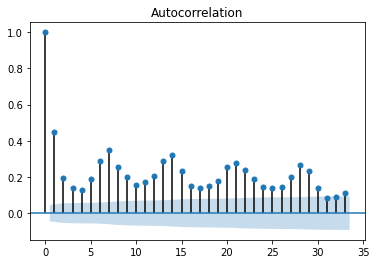

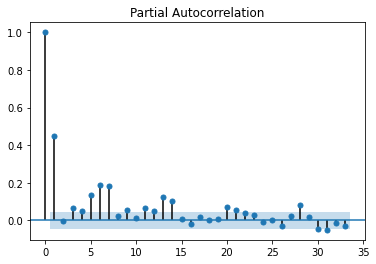

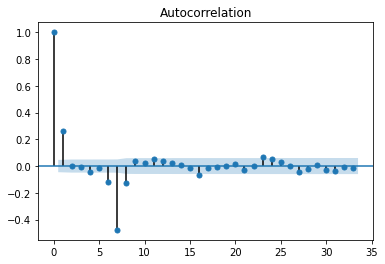

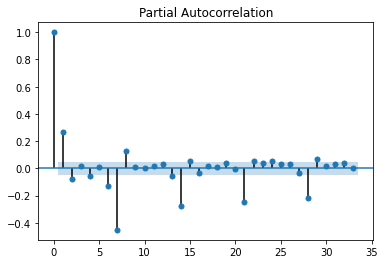

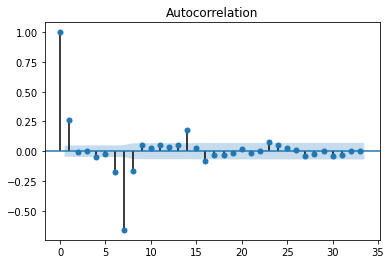

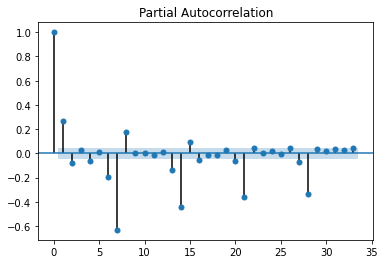

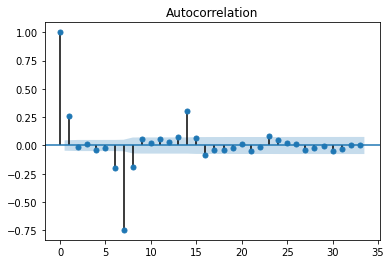

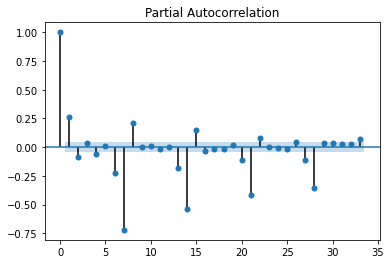

In [19]:
#The second thing to note in these results is the output of the Durbin-Watson test
#which measures the degree of LAG-1 auto-correlation in the residual errors of regression. 
##A value of 2 implies no LAG-1 auto-correlation. A value closer to 0 implies strong positive auto-correlation
#while a value close to 4 implies a strong negative auto-correlation at LAG-1 among the residuals errors ε.

import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(olsr_results.resid, alpha=0.05)
tsa.plot_pacf(olsr_results.resid, alpha=0.05)
plt.show()


olsr_resid_diff_1 = olsr_results.resid.diff(periods = 7)
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()
tsa.plot_acf(olsr_resid_diff_1, alpha=0.05)
tsa.plot_pacf(olsr_resid_diff_1, alpha=0.05)
plt.show()


olsr_resid_diff_2 = olsr_resid_diff_1.diff(periods = 7)
olsr_resid_diff_2 = olsr_resid_diff_2.dropna()
tsa.plot_acf(olsr_resid_diff_2, alpha=0.05)
tsa.plot_pacf(olsr_resid_diff_2, alpha=0.05)
plt.show()

olsr_resid_diff_3 = olsr_resid_diff_2.diff(periods = 7)
olsr_resid_diff_3 = olsr_resid_diff_3.dropna()
tsa.plot_acf(olsr_resid_diff_3, alpha=0.05)
tsa.plot_pacf(olsr_resid_diff_3, alpha=0.05)
plt.show()



(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <a list of 10 Text major ticklabel objects>)

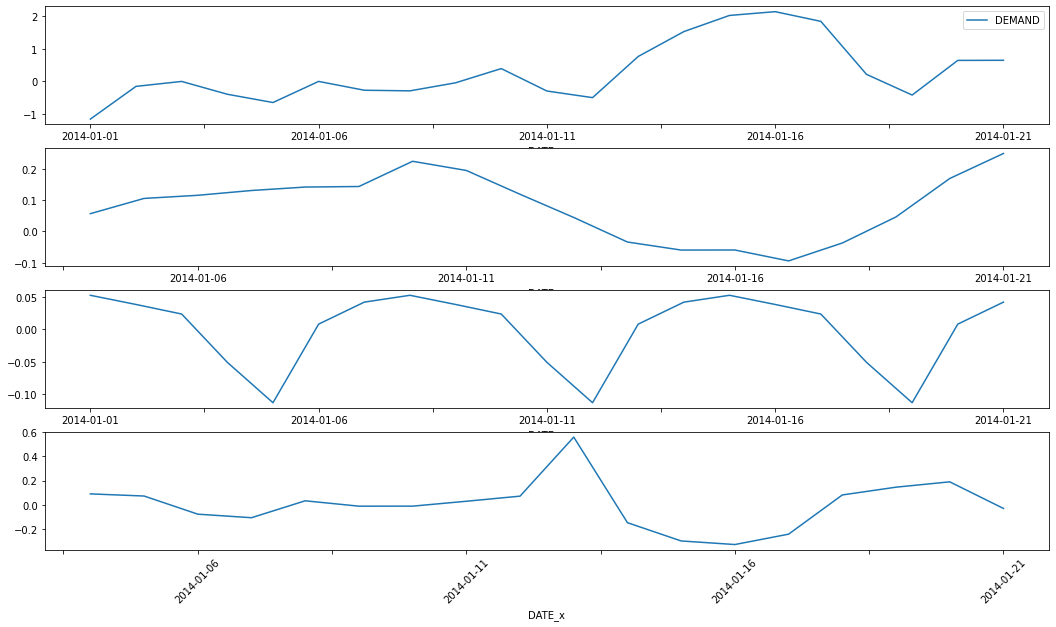

In [20]:
decomp = seasonal_decompose(olsr_results.resid, period=7)
trends = decomp.trend
seasonals = decomp.seasonal
resids = decomp.resid
fig, axes = plt.subplots(4,1,  figsize= (18,10))
demand[:21].plot(ax=axes[0])
trends[:21].plot(ax=axes[1])
seasonals[:21].plot(ax=axes[2])
resids[:21].plot(ax=axes[3])
plt.xticks(rotation=45)
# plt.xticks(resids['Date_x'])
# ax = plt.gca()
# ax.set_xticklabels(resids['Date_x'][::2], rotation='vertical')

In [21]:
# p , q and d terms and why
# p is the order of the AR term. It refers to the number of lags of Y to be used as predictors.
# q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
# d is the number of differencing required to make the time series stationary, The value of d, therefore, is the minimum number of differencing needed to make the series stationary.
# And if the time series is already stationary, then d = 0.
Y_train = Y_train.asfreq('D')
X_train = X_train.asfreq('D')
sarimax_model = ARIMA(endog=Y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,7), freq= 'D')
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

C:\Users\raman\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            DEMAND   No. Observations:                 1826
Model:             ARIMA(2, 0, 2)x(0, 1, [1], 7)   Log Likelihood                2354.848
Date:                           Wed, 18 Nov 2020   AIC                          -4685.697
Time:                                   11:57:54   BIC                          -4619.624
Sample:                               01-01-2014   HQIC                         -4661.320
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
MAX_TEMP         -0.0096      0.004     -2.571      0.010      -0.017      -0.002
Holiday_Flag     -0.1879      0.006    -32.290      0.000      -0.199      -0.176
Weekened_Flag  1.623e-10   3.78e-11      4.291      0.000    8.82e-11    2.36e-10
MaxT_Squared      0.0601      0.003     20.174      0.000       0.054       0.066
MinT_Squared      0.0343      0.004      8.898      0.000       0.027       0.042
MinMax            0.0390      0.006      6.788      0.000       0.028       0.050
ar.L1             0.1628      0.040      4.052      0.000       0.084       0.242
ar.L2             0.7279      0.035     20.509      0.000       0.658       0.797
ma.L1             0.4901      0.040     12.358      0.000       0.412       0.568
ma.L2            -0.3613      0.021    -17.406      0.000      -0.402      -0.321
ma.S.L7          -0.9535      0.009   -100.626      0.000      -0.972      -0.935
sigma2            0.0044      0.000     39.975      0.000       0.004       0.005
===================================================================================
Ljung-Box (Q):                      119.85   Jarque-Bera (JB):               239.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.20
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+18. Standard errors may be unstable.
"""

In [22]:
# import pmdarima as pm

# # Seasonal - fit stepwise auto-ARIMA
# sxmodel = pm.auto_arima(Y_train, X_train,
#                            test='adf',
#                            max_p=5, max_q=5, m=7,
#                            start_P=0, seasonal=True,
#                            d=None, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=False)

# sxmodel.summary()

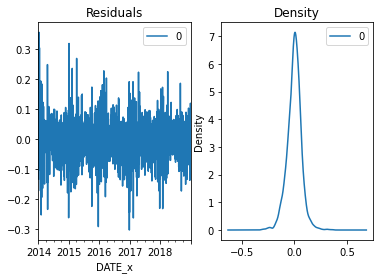

In [23]:
# Plot residual errors
residuals = pd.DataFrame(sarimax_results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [25]:
# # MODEL PREDICTIONS
df2 = pd.read_csv(settings.ASSEMBLED_DIR + "\\Test_data1.csv")
df1 =df2[df2['STATE_VIC']==1]
df1.sort_values(by=['YEAR', 'MONTH', 'DAY'], inplace=True)
df1.set_index(df1['DATE_x'], inplace = True)

X_test = df1.drop(['DEMAND','MONTH', 'YEAR', 'DAY','DATE_x', 'STATE_QLD', 'STATE_VIC', 'STATE_SA', 'STATE_TAS'], axis='columns')

Y_test = df2.loc[df2['STATE_VIC']==1, ['DEMAND', 'DATE_x']]
Y_test.set_index(Y_test['DATE_x'], inplace = True)
Y_test.drop(['DATE_x'], axis = 'columns', inplace = True)
Actuals_2019 = pd.Series.to_numpy(Y_test['DEMAND'])

X_test['MaxT_Squared']= (X_test['MAX_TEMP'])**2
X_test['MinT_Squared']= X_test['MIN_TEMP']**2
X_test['MaxMin']= X_test['MIN_TEMP']*X_test['MAX_TEMP']
X_test.drop(['MIN_TEMP'], axis = 'columns', inplace = True)

X_test.index = pd.DatetimeIndex(X_test.index).to_period('D')
Y_test.index = pd.DatetimeIndex(Y_test.index).to_period('D')

predictions = sarimax_results.get_forecast(steps=60, exog=X_test[:60])
predictions.summary_frame() 

predictions_2019 =sarimax_results.get_forecast(steps=365, exog=X_test)
pre_2019 = predictions_2019.summary_frame()
forecast_2019 = pd.Series.to_numpy(pre_2019['mean'])
# predictions_all = sarimax_results.get_forecast(exog=X_test)

<ipython-input-25-b10d7ca793cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_values(by=['YEAR', 'MONTH', 'DAY'], inplace=True)


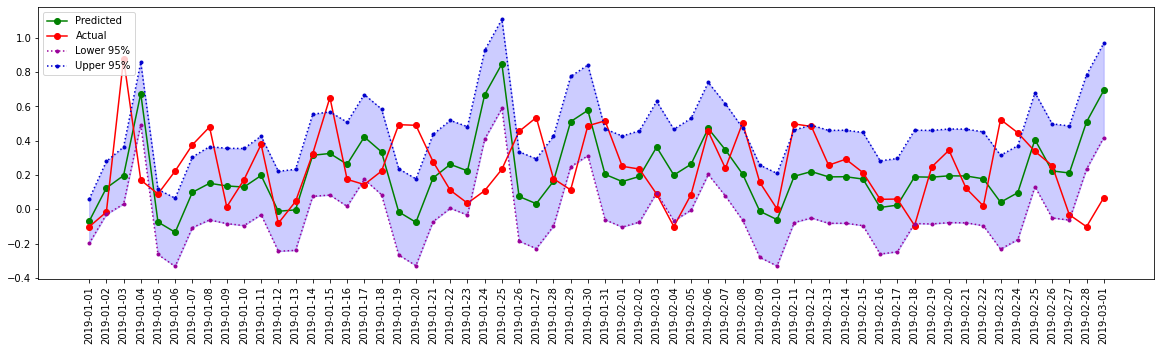

In [26]:
plt.figure(figsize=(20,5))
predicted, = plt.plot((X_test[:60].index).astype(str), predictions.summary_frame()['mean'], 'go-', label='Predicted')
actual, = plt.plot((X_test[:60].index).astype(str), Y_test[:60], 'ro-', label='Actual')
lower, = plt.plot((X_test[:60].index).astype(str), predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
upper, = plt.plot((X_test[:60].index).astype(str), predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between((X_test[:60].index).astype(str), predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])
plt.xticks(rotation=90)
plt.show()

In [27]:
# # MODEL PREDICTIONS
df2 = pd.read_csv(settings.ASSEMBLED_DIR  + "\\Test_data2.csv")
df2.sort_values(by=['YEAR', 'MONTH', 'DAY'], inplace=True)
df1 =df2[(df2['STATE_VIC']==1) & (df2['YEAR']== 2020)]

df1.set_index(df1['DATE_x'], inplace = True)

X_test = df1.drop(['DEMAND','MONTH', 'YEAR', 'DAY','DATE_x', 'STATE_QLD', 'STATE_VIC', 'STATE_SA', 'STATE_TAS'], axis='columns')

Y_test = df2.loc[df2['STATE_VIC']==1, ['DEMAND', 'DATE_x']]
Y_test.set_index(Y_test['DATE_x'], inplace = True)
Y_test.drop(['DATE_x'], axis = 'columns', inplace = True)
Actuals_2020 = pd.Series.to_numpy(Y_test['DEMAND'])


X_test['MaxT_Squared']= (X_test['MAX_TEMP'])**2
X_test['MinT_Squared']= X_test['MIN_TEMP']**2
predictions = sarimax_results.get_forecast(steps=30, exog=X_test[:30])
predictions.summary_frame()

DEMAND,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,0.051015,0.066084,-0.078507,0.180538
2019-01-02,0.037778,0.078923,-0.116909,0.192464
2019-01-03,0.143673,0.084885,-0.022698,0.310045
2019-01-04,-0.019470,0.092397,-0.200566,0.161626
2019-01-05,-0.068149,0.096749,-0.257773,0.121475
2019-01-06,-0.157089,0.101666,-0.356350,0.042172
2019-01-07,0.023934,0.104929,-0.181724,0.229592
2019-01-08,-0.019476,0.109144,-0.233394,0.194441
2019-01-09,0.024364,0.112037,-0.195224,0.243952
2019-01-10,0.011765,0.114764,-0.213169,0.236698


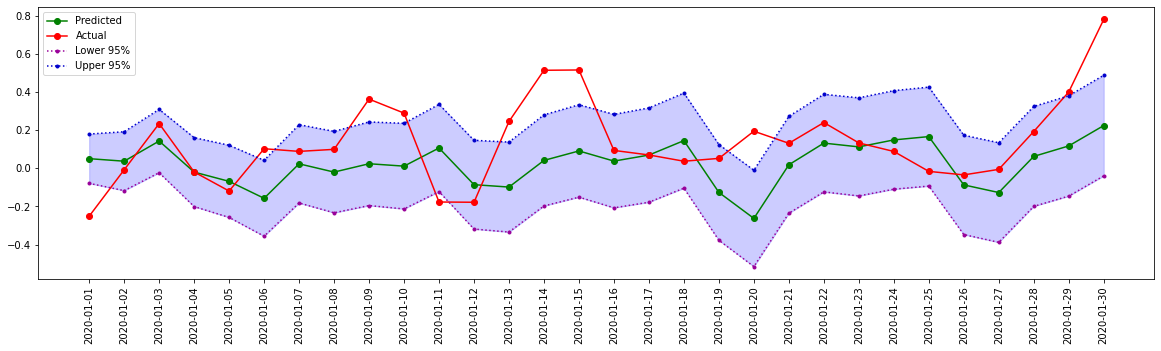

In [28]:
plt.figure(figsize=(20,5))
predicted, = plt.plot(X_test[:30].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')
actual, = plt.plot(X_test[:30].index, Y_test[:30], 'ro-', label='Actual')
lower, = plt.plot(X_test[:30].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
upper, = plt.plot(X_test[:30].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(X_test[:30].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])
plt.xticks(rotation=90)
plt.show()

In [29]:
predictions_2020 = sarimax_results.get_forecast(steps=290, exog=X_test)

In [30]:
pre_2020 = predictions_2020.summary_frame()
forecast_2020 = pd.Series.to_numpy(pre_2020['mean'])

In [31]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})


In [32]:
forecast_accuracy(forecast_2020, Actuals_2020)

{'mape': 1.5539521653797386,
 'me': -0.021714464811402486,
 'mae': 0.15271763637111088,
 'mpe': -0.28450711468318524,
 'rmse': 0.21490478805194055,
 'corr': 0.44210856142160965}

In [33]:
forecast_accuracy(forecast_2019, Actuals_2019)

{'mape': 3.6382829013563565,
 'me': -0.04225245898990273,
 'mae': 0.2014008796498032,
 'mpe': 1.1623362956389114,
 'rmse': 0.25448301006096014,
 'corr': 0.052210466677228264}

In [34]:
# Model stilll needs working on optimization and improvement